In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import s3fs
import seaborn as sns

from functools import reduce

In [2]:
quotes = pd.read_parquet("quotes_bref_mediapart_1981-2025.parquet")

## 0. Exploration

In [3]:
len(quotes["text_id"].unique())

473956

Attention, l'identifiant `text_id` n'est pas unique, mais fréquemment partagé par 2 à 3 articles. 

In [4]:
overlapping_ids = quotes.groupby("text_id")["journal"].nunique()
print(len(overlapping_ids[overlapping_ids == 2]))
print(len(overlapping_ids[overlapping_ids == 3]))

53567
5286


Pour identifier les articles, il faut combiner `text_id` avec le journal et l'année : on trouve 563 036 articles dans la base.

In [5]:
print(quotes.groupby(["text_id", "journal", "year"]).ngroups)

quotes["article_key"] = quotes[["text_id", "journal", "year"]].astype(str).agg("_".join, axis=1)

563007


In [6]:
df = (
    quotes.groupby("journal")
    .agg(
        articles=("article_key", "nunique"),
        citations=("article_key", "size"),
        journalists=("author", "nunique"),
        sources=("person_name_standardized_low", "nunique"),
    )
    .reset_index()
)

totals = df[["articles", "citations", "journalists", "sources"]].sum().to_frame().T
totals.insert(0, "journal", "Total")

df = pd.concat([df, totals], ignore_index=True)
df.style.hide(axis=0)

journal,articles,citations,journalists,sources
La Croix,55259,212556,2633,2605
Le Figaro,181650,855618,16530,3133
Le Monde,182672,922258,15540,3225
Libération,99849,495725,8820,2970
Mediapart,43577,319153,1646,2425
Total,563007,2805310,45169,14358


En étudiant la répartition des nuances politiques entre les articles, on obtient un total supérieur car chaque article peut citer plusieurs nuances...

In [7]:
df = (
    quotes.groupby("Alignement")
    .agg(
        articles=("article_key", "nunique"),
        citations=("article_key", "size"))
    .reset_index()
)

totals = df[["articles", "citations"]].sum().to_frame().T
totals.insert(0, "Alignement", "Total")
df = pd.concat([df, totals], ignore_index=True)
total_citations = df.loc[df["Alignement"] == "Total", "citations"].values[0]
df["share_citations"] = 100 * df["citations"] / total_citations
df.style.hide(axis=0).format({"share_citations": "{:.2f}"})

Alignement,articles,citations,share_citations
autonomiste,1942,4761,0.17
autre,2561,5937,0.21
centre,96688,379350,13.54
centredroite_droite,309454,1219883,43.54
centregauche_gauche,237526,879298,31.38
extremedroite_droiteradicale,48530,174364,6.22
extremegauche_gaucheradicale,46296,138192,4.93
Total,742997,2801785,100.00


In [8]:
align_per_article = (
    quotes.groupby("article_key")["Alignement"]
    .nunique()
    .reset_index(name="n_unique_alignements")
)

distribution = (
    align_per_article["n_unique_alignements"]
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "n_unique_alignements", "count": "n_articles"})
)

distribution.style.hide(axis=0)

n_unique_alignements,n_articles
0,449
1,425566
2,105724
3,23000
4,6695
5,2013
6,23


## 1. Outcomes

In [9]:
# Translate political nuances
def map_political_alignment(df, col='political_alignment'):
    mapping = {
        'centredroite_droite': 'Right',
        'centregauche_gauche': 'Left',
        'extremegauche_gaucheradicale': 'Far left',
        'centre': 'Center',
        'extremedroite_droiteradicale': 'Far right',
        'autre': 'Other'
    }
    df[col] = df[col].replace(mapping)
    return df

quotes.rename(columns={'Alignement': 'political_alignment'}, inplace=True)
quotes = map_political_alignment(quotes)

# Rename journals
quotes['journal'] = quotes['journal'].replace('Mediapart', 'Médiapart')

# Convert date to datetime if it isn't already
if not pd.api.types.is_datetime64_any_dtype(quotes['date']):
    quotes['date'] = pd.to_datetime(quotes['date'])

# Extract month from date
quotes['month'] = quotes['date'].dt.to_period('M')

In [10]:
# Filter quotes to only include main political alignments
valid_alignments = ['Far right', 'Right', 'Center', 'Left', 'Far left', 'Other']
filtered_quotes = quotes[quotes['political_alignment'].isin(valid_alignments)].copy()

print(f"{len(quotes)} quotations in original dataset")
print(f"{len(filtered_quotes)} quotations after filtration of political alignments")

2807155 quotations in original dataset
2797024 quotations after filtration of political alignments


In [11]:
# Select relevant grouping variables
group_vars_short = ['month', 'journal']
group_vars_long = ['month', 'journal', 'political_alignment']

In [12]:
# Number and share of quotes
quotes_counts = (
    filtered_quotes.groupby(group_vars_long)
    .size()
    .reset_index(name='quote_count'))
quotes_total_counts = filtered_quotes.groupby(group_vars_short).size().reset_index(name='quotes_nb')
quotes_data = pd.merge(quotes_counts, quotes_total_counts, on=group_vars_short)
quotes_data['quotes_share'] = quotes_data['quote_count'] / quotes_data['quotes_nb']

In [13]:
# Number and share of articles with quotes
art_counts = filtered_quotes.groupby(group_vars_long)['text_id'].nunique().reset_index()
art_total_counts = filtered_quotes.groupby(group_vars_short)['text_id'].nunique().reset_index(name='art_nb')
art_data = pd.merge(art_counts, art_total_counts, on=group_vars_short)
art_data['art_share'] = art_data['text_id'] / art_data['art_nb']
art_data.drop(columns='text_id', inplace=True)

In [14]:
# Quote length
filtered_quotes['quote_length'] = filtered_quotes['quote_text'].apply(lambda x: len(x.strip('« » ')))
length_data = filtered_quotes.groupby(group_vars_long)['quote_length'].mean().reset_index(name='mean_quote_length')

In [15]:
# Quote style
type_counts = filtered_quotes.groupby(group_vars_long + ['quote_type']).size().reset_index(name='type_count')
type_total_counts = filtered_quotes.groupby(group_vars_long).size().reset_index(name='quotes_type_nb')
type_data = pd.merge(type_counts, type_total_counts, on=group_vars_long)
type_data['type_quotes_share'] = type_data['type_count'] / type_data['quotes_type_nb']

direct_data = (
    type_data[type_data['quote_type'] == 'Direct']
    .rename(columns={'type_quotes_share': 'type_direct_share'})
    .drop(columns=['quote_type', 'type_count', 'quotes_type_nb']))

undirect_data = (
    type_data[type_data['quote_type'] == 'Indirect']
    .rename(columns={'type_quotes_share': 'type_undirect_share'})
    .drop(columns=['quote_type', 'type_count', 'quotes_type_nb']))

mixed_data = (
    type_data[type_data['quote_type'] == 'Mixed']
    .rename(columns={'type_quotes_share': 'type_mixed_share'})
    .drop(columns=['quote_type', 'type_count', 'quotes_type_nb']))

In [16]:
# Personalities
person_data = filtered_quotes.groupby(group_vars_long)['person_name_standardized_low'].nunique().reset_index(name='personalities_nb')

In [17]:
# Generate all months / political_alignment combinations to generate null values if necessary
unique_months = filtered_quotes['month'].unique()

unique_journals = filtered_quotes['journal'].unique()
journal_min_months = (
    filtered_quotes.groupby('journal')['month']
    .min()
    .reset_index()
    .rename(columns={'month': 'min_month'}))

all_combinations = pd.DataFrame(
    list(itertools.product(unique_months, unique_journals, valid_alignments)),
    columns=['month', 'journal', 'political_alignment'])
all_combinations = all_combinations.merge(journal_min_months, on='journal', how='left')
all_combinations = all_combinations[all_combinations['month'] >= all_combinations['min_month']]
all_combinations = all_combinations.drop(columns='min_month')

In [18]:
# Final dataframe
dfs = [all_combinations, quotes_data, art_data, length_data, direct_data, undirect_data, mixed_data, person_data]
model_data = reduce(
    lambda left, right: pd.merge(left, right, on=group_vars_long, how='outer'), 
    dfs)

## 2. Élections législatives et sièges à l'Assemblée nationale
### Identification des cycles électoraux

In [19]:
legi_dates = [
    "19/03/1978",
    "21/06/1981",
    "16/03/1986",
    "11/06/1988",
    "28/03/1993",
    "01/06/1997",
    "16/06/2002",
    "17/06/2007",
    "17/06/2012",
    "18/06/2017",
    "19/06/2022",
    "06/07/2024"]

legi_dates = pd.to_datetime(legi_dates, format="%d/%m/%Y").to_period('M').sort_values()

In [20]:
# Find the year of the latest election
def find_last_legi_year(current_month):
    relevant_elections = legi_dates[legi_dates < current_month]

    if not relevant_elections.empty:
        return relevant_elections.max().year
    else:
        return pd.NA

model_data['last_leg'] = model_data['month'].apply(find_last_legi_year)
model_data['last_leg'] = pd.to_datetime(model_data['last_leg'], format="%Y")

### Résultats

In [21]:
na_seats = pd.read_csv("data/na_seats.csv")

In [22]:
na_seats.drop(columns=['Groupe parlementaire', 'Sièges'], inplace=True)

na_seats.rename(columns={
    'Nuance': 'political_alignment',
    'Année élection': 'last_leg',
    'Proportion sièges': 'na_share'}, inplace=True)
na_seats = map_political_alignment(na_seats)

na_seats = na_seats.dropna(subset=['political_alignment']).reset_index(drop=True)
na_seats['na_share'] = na_seats['na_share'].replace(',', '.', regex=True)
na_seats['na_share'] = na_seats['na_share'].apply(pd.to_numeric, errors='coerce')
na_seats['last_leg'] = pd.to_datetime(na_seats['last_leg'], format="%Y")

na_seats = na_seats.groupby(['political_alignment', 'last_leg'], as_index=False)['na_share'].sum()

In [23]:
#model_data = pd.merge(model_data, elec_leg, on=['political_alignment', 'last_leg'], how='left')
model_data = pd.merge(model_data, na_seats, on=['political_alignment', 'last_leg'], how='left')
model_data.drop(columns='last_leg', inplace=True)

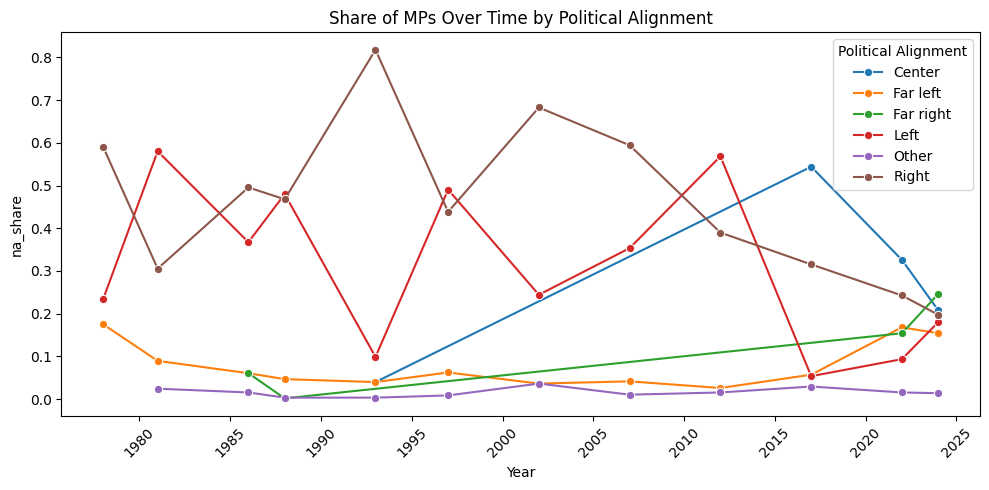

In [24]:
na_seats['last_leg'] = pd.to_datetime(na_seats['last_leg'])

plt.figure(figsize=(10, 5))
sns.lineplot(data=na_seats, x='last_leg', y='na_share', hue='political_alignment', marker='o')
plt.title('Share of MPs Over Time by Political Alignment')
plt.xlabel('Year')
plt.ylabel('na_share')
plt.legend(title='Political Alignment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Élections présidentielles
### Identification des cycles électoraux

In [25]:
presi_dates = [
    "05/07/1974",
    "26/04/1981",
    "24/04/1988",
    "23/04/1995",
    "21/04/2002",
    "22/04/2007",
    "22/04/2012",
    "21/04/2017",
    "10/04/2022"]

presi_dates = pd.to_datetime(presi_dates, dayfirst=True).to_period('M').sort_values()
next_pres_months = (presi_dates + 1).to_timestamp()

In [26]:
def find_last_presi_year(current_month):
    relevant_elections = presi_dates[presi_dates < current_month]

    if not relevant_elections.empty:
        return relevant_elections.max().year
    else:
        return pd.NA

model_data['last_pres'] = model_data['month'].apply(find_last_presi_year)
model_data['last_pres'] = pd.to_datetime(model_data['last_pres'], format="%Y")

In [27]:
def create_pres_dummy(month, lag):
    return int(month in (presi_dates + lag))

# Dummies for pre-electoral period
for lag in range(0, -6, -1):
    model_data[f'pre_{-lag}'] = model_data['month'].apply(lambda m: create_pres_dummy(m, lag))

# Dummies for post-electoral period
## Removing those for 1995 as no legislative election followed the presidential election that year
for lag in range(1, 3):
    model_data[f'post_{lag}'] = model_data['month'].apply(lambda m: create_pres_dummy(m, lag))
model_data.loc[model_data["month"] == pd.Period('1995-05', freq='M'), 'post_1'] = 0
model_data.loc[model_data["month"] == pd.Period('1995-06', freq='M'), 'post_2'] = 0
model_data['post_dum'] = model_data['post_1'] + model_data['post_2']

# Dummies for inter-electoral period
model_data['inter_dum'] = (
    (model_data[['pre_0', 'pre_1', 'pre_2', 'pre_3', 'pre_4', 'pre_5', 'post_dum']].sum(axis=1) == 0)
).astype(int)

### Résultats électoraux

In [28]:
elec_pres = pd.read_csv("data/elec_pres.csv")

In [29]:
elec_pres.drop(columns=['Candidat', 'Parti', 'Résultat T1 en %', 'Résultat T2 en %', 'Résultat T2'], inplace=True)

elec_pres.rename(columns={
    'Nuance': 'political_alignment',
    'Année élection': 'last_pres',
    'Résultat T1': 'pres_votes_share',
    'Rang T2': 'r2_rank'}, inplace=True)
elec_pres = map_political_alignment(elec_pres)

elec_pres = elec_pres.dropna(subset=['political_alignment']).reset_index(drop=True)
elec_pres['pres_votes_share'] = elec_pres['pres_votes_share'].replace(',', '.', regex=True)
elec_pres['pres_votes_share'] = elec_pres['pres_votes_share'].apply(pd.to_numeric, errors='coerce')
elec_pres['last_pres'] = pd.to_datetime(elec_pres['last_pres'], format="%Y")

elec_pres = elec_pres.groupby(['political_alignment', 'last_pres'], as_index=False)[['pres_votes_share', 'r2_rank']].sum()

rank_dummies = pd.get_dummies(elec_pres['r2_rank'].astype(int), prefix='r2_rank').astype(int)
elec_pres = pd.concat([elec_pres, rank_dummies], axis=1)
elec_pres.drop(columns = ['r2_rank', 'r2_rank_0'], inplace=True)

In [30]:
model_data = pd.merge(model_data, elec_pres, on=['political_alignment', 'last_pres'], how='left')
# model_data.drop(columns='last_pres', inplace=True)

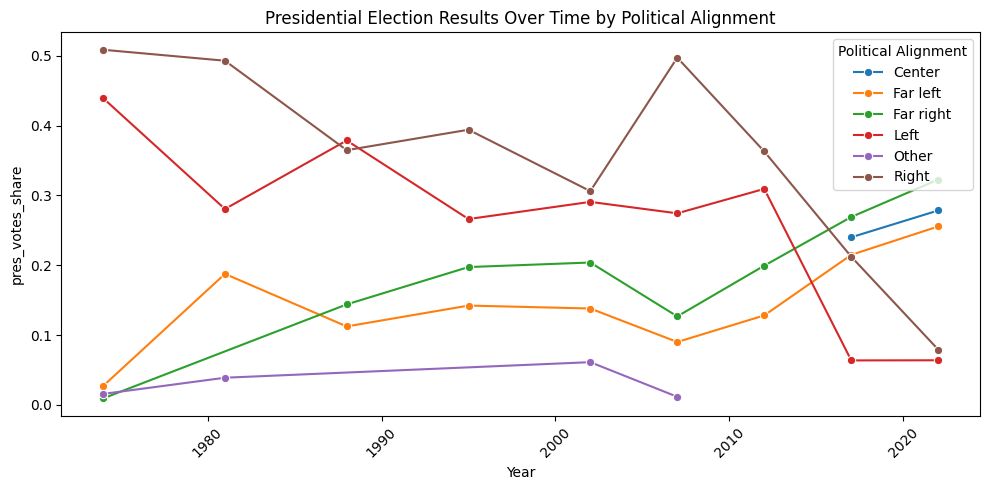

In [31]:
elec_pres['last_pres'] = pd.to_datetime(elec_pres['last_pres'])

plt.figure(figsize=(10, 5))
sns.lineplot(data=elec_pres, x='last_pres', y='pres_votes_share', hue='political_alignment', marker='o')
plt.title('Presidential Election Results Over Time by Political Alignment')
plt.xlabel('Year')
plt.ylabel('pres_votes_share')
plt.legend(title='Political Alignment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sondages

In [32]:
poll_pres = pd.read_csv("data/poll_pres.csv")

In [33]:
poll_pres.rename(columns={
    'Nuance': 'political_alignment',
    'Date sondage': 'month',
    'Résultat': 'pres_poll_result'}, inplace=True)

poll_pres = map_political_alignment(poll_pres)

poll_pres = poll_pres.dropna(subset=['political_alignment']).reset_index(drop=True)
poll_pres['pres_poll_result'] = poll_pres['pres_poll_result'].replace(',', '.', regex=True)
poll_pres['pres_poll_result'] = poll_pres['pres_poll_result'].apply(pd.to_numeric, errors='coerce')
poll_pres['month'] = pd.to_datetime(poll_pres['month'], format="%Y-%m").dt.to_period('M')

poll_pres = poll_pres.groupby(['political_alignment', 'month'], as_index=False)['pres_poll_result'].sum()

In [34]:
model_data = pd.merge(model_data, poll_pres, on=['political_alignment', 'month'], how='left')

/var/folders/39/44r9ct3n4hj3sdf26gj5wgp40000gn/T/ipykernel_93711/561287155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, break_rows]).sort_index()


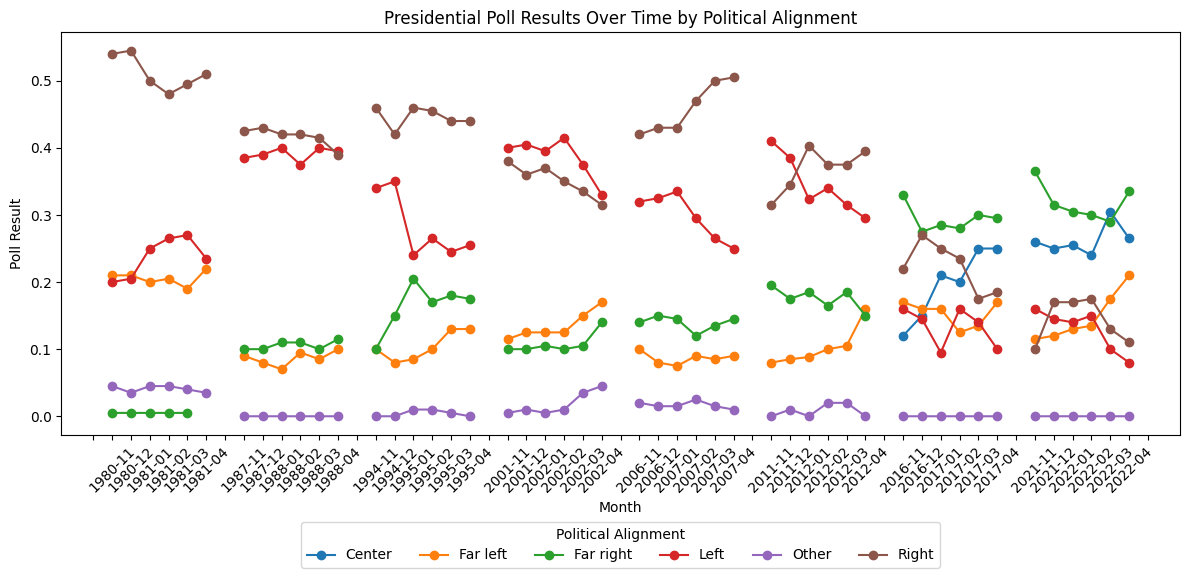

In [35]:
poll_pres['month_ts'] = poll_pres['month'].dt.to_timestamp()

plot_data = poll_pres.pivot_table(index='month_ts',
                                  columns='political_alignment',
                                  values='pres_poll_result')
plot_data = plot_data.dropna(how='all')

break_rows = pd.DataFrame(index=next_pres_months, columns=plot_data.columns)
plot_data = pd.concat([plot_data, break_rows]).sort_index()
plot_data.index = plot_data.index.strftime('%Y-%m')

x_labels = plot_data.index.tolist()
is_break_row = plot_data.isna().all(axis=1)
x_labels_filtered = [label if not is_break else '' for label, is_break in zip(x_labels, is_break_row)]

plt.figure(figsize=(12, 6))
for col in plot_data.columns:
    plt.plot(plot_data.index, plot_data[col], marker='o', label=col)

plt.title('Presidential Poll Results Over Time by Political Alignment')
plt.xlabel('Month')
plt.ylabel('Poll Result')
plt.legend(title='Political Alignment', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_data.columns))

plt.xticks(ticks=np.arange(len(plot_data.index)), labels=x_labels_filtered, rotation=45)
plt.tight_layout()
plt.show()

poll_pres.drop(columns='month_ts', inplace=True)

## 4. Élections européennes
### Identification des cycles électoraux

In [36]:
europ_dates = [
    "10/06/1979",
    "17/06/1984",
    "18/06/1989",
    "12/06/1994",
    "13/06/1999",
    "13/06/2004",
    "07/06/2009",
    "25/05/2014",
    "26/05/2019",
    "09/06/2024"]

europ_dates = pd.to_datetime(europ_dates, dayfirst=True).to_period('M').sort_values()

In [37]:
# Find the year of the latest election
def find_last_europ_year(current_month):
    relevant_elections = europ_dates[europ_dates < current_month]

    if not relevant_elections.empty:
        return relevant_elections.max().year
    else:
        return pd.NA

model_data['last_europ'] = model_data['month'].apply(find_last_europ_year)
model_data['last_europ'] = pd.to_datetime(model_data['last_europ'], format="%Y")

In [38]:
# Create dummies for the periods between an European election and the next presidential election
model_data['europ_dummy_long'] = 0

for e_date in europ_dates:
    # Find the first presi_date after the current europ_date
    next_presi = next((p for p in presi_dates if p > e_date), None)

    if next_presi is not None:
        mask = (model_data['month'] > e_date) & (model_data['month'] < next_presi)
    else:
        mask = model_data['month'] > e_date

    model_data.loc[mask, 'europ_dummy_long'] = 1

In [39]:
# Create dummies for the trimesters following European elections
target_months = set()
for p in europ_dates:
    for i in range(3):
        target_months.add(p + i)

model_data['europ_dummy_short'] = model_data['month'].isin(target_months).astype(int)

### Résultats

In [40]:
elec_europ = pd.read_csv("data/elec_europ.csv")

In [41]:
elec_europ.drop(columns=['Parti', 'Résultat en %', 'Sièges'], inplace=True)

elec_europ.rename(columns={
    'Nuance': 'political_alignment',
    'Année élection': 'last_europ',
    'Résultat': 'europ_votes_share'}, inplace=True)

elec_europ = map_political_alignment(elec_europ)

elec_europ = elec_europ.dropna(subset=['political_alignment']).reset_index(drop=True)
elec_europ['europ_votes_share'] = elec_europ['europ_votes_share'].replace(',', '.', regex=True)
elec_europ['europ_votes_share'] = elec_europ['europ_votes_share'].apply(pd.to_numeric, errors='coerce')
elec_europ['last_europ'] = pd.to_datetime(elec_europ['last_europ'], format="%Y")

elec_europ = elec_europ.groupby(['political_alignment', 'last_europ'], as_index=False)['europ_votes_share'].sum()

In [42]:
model_data = pd.merge(model_data, elec_europ, on=['political_alignment', 'last_europ'], how='left')
model_data.drop(columns='last_europ', inplace=True)

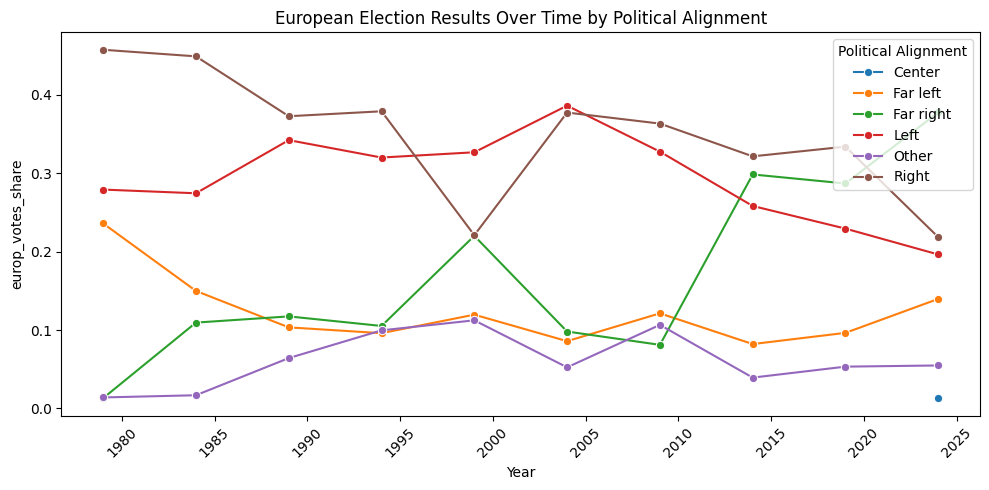

In [43]:
elec_europ['last_europ'] = pd.to_datetime(elec_europ['last_europ'])

plt.figure(figsize=(10, 5))
sns.lineplot(data=elec_europ, x='last_europ', y='europ_votes_share', hue='political_alignment', marker='o')
plt.title('European Election Results Over Time by Political Alignment')
plt.xlabel('Year')
plt.ylabel('europ_votes_share')
plt.legend(title='Political Alignment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Indicatrice de représentation au gouvernement
Comment traiter les cohabitations ? En l'état le bonus est seulement accordé à la nuance du Premier ministre.

- **centre**
  - 19/06/2017 - 05/09/2024 + droite ?
- **centredroite_droite**
  - 05/04/1978 - 22/06/1981
  - 20/03/1986 - 10/05/1988
  - 29/03/1993 - 02/06/1997
  - 06/05/2002 - 10/05/2012
  - 05/09/2024 - 31/12/2024
- **centregauche_gauche**
  - 22/06/1981 - 20/03/1986
  - 10/05/1988 - 29/03/1993 + centre ?
  - 02/06/1997 - 06/05/2002
  - 15/05/2012 - 19/06/2017
- **extremegauche_gaucheradicale**
  - 22/06/1981 - 17/07/1984
  - 02/06/1997 - 06/05/2002

In [44]:
gov_periods = {
    "Far right": [],
    "Right": [
        ("1978-05-04", "1981-05-13"),
        ("1986-03-20", "1988-05-10"),
        ("1993-03-29", "1997-06-02"),
        ("2002-05-06", "2012-05-10"),
        ("2017-06-19", "2024-09-05"),
        ("2024-09-05", "2025-07-01"),],
    "Center": [
        ("2017-06-19", "2024-09-05")],
    "Left": [
        ("1981-05-22", "1986-03-20"),
        ("1988-05-10", "1993-03-29"),
        ("1997-06-02", "2002-05-06"),
        ("2012-05-15", "2017-06-19")],
    "Far left": [
        ("1981-06-23", "1984-07-17"),
        ("1997-06-02", "2002-05-06")
    ],
    "Other": [],
}

In [45]:
all_start_dates = [pd.to_datetime(start) for periods in gov_periods.values() for start, _ in periods]
all_end_dates = [pd.to_datetime(end) for periods in gov_periods.values() for _, end in periods]
min_date = min(all_start_dates).replace(day=1)
max_date = max(all_end_dates).replace(day=1)
all_months = pd.date_range(start=min_date, end=max_date, freq="MS")

data = []

for alignment, periods in gov_periods.items():
    active_months = pd.Series(0, index=all_months)
    for start, end in periods:
        period_range = pd.date_range(
            # Adding one month at the begining of each period to avoid overlapping dummies
            start = pd.to_datetime(start).replace(day=1) + pd.DateOffset(months=1),
            end = pd.to_datetime(end).replace(day=1),
            freq = "MS")
        
        active_months.loc[period_range] = 1

    df = pd.DataFrame({
        "month": active_months.index.to_period('M'),
        "political_alignment": alignment,
        "government": active_months.values})
    data.append(df)

gov_dummies = pd.concat(data)
gov_dummies.sort_values(by=["month", "political_alignment"], inplace=True)
gov_dummies.reset_index(drop=True, inplace=True)

In [46]:
# Divide by 2 when 2 political nuances are part of the government
monthly_sum = gov_dummies.groupby('month')['government'].transform('sum')

gov_dummies['government'] = np.where(
    monthly_sum > 1,
    gov_dummies['government'] / monthly_sum,
    gov_dummies['government'])

In [47]:
model_data = pd.merge(model_data, gov_dummies, on=['political_alignment', 'month'], how='left')

## Sauvegarde

In [48]:
model_data = model_data.fillna(0)
model_data.to_parquet(f"data/model_data.parquet", index=False)

In [49]:
# Create a dataset without journals
outcomes_njl = model_data.groupby(['month', 'political_alignment'], as_index=False)[
    ['quotes_share', 'art_share', 'mean_quote_length', 'type_direct_share', 'type_undirect_share', 'type_mixed_share', 'personalities_nb']
    ].mean()

quote_counts_njl = model_data.groupby(['month', 'political_alignment'], as_index=False)[['quote_count']].sum()
quote_counts_njl.rename(columns={'quote_count': 'quote_nb'}, inplace=True)

art_counts_njl = filtered_quotes.groupby(['month', 'political_alignment'])['text_id'].nunique().reset_index()
art_counts_njl.rename(columns={'text_id': 'art_nb'}, inplace=True)

controls_njl = model_data.groupby(['month', 'political_alignment'], as_index=False)[
    ['na_share', 'pre_0', 'pre_1', 'pre_2', 'pre_3', 'pre_4', 'pre_5',
     'post_1', 'post_2', 'post_dum', 'inter_dum', 'last_pres',
     'europ_dummy_long', 'europ_dummy_short', 'europ_votes_share','pres_votes_share',
     'r2_rank_1', 'r2_rank_2', 'pres_poll_result','government']
    ].first()

dfs = [outcomes_njl, quote_counts_njl, art_counts_njl, controls_njl]
model_data_njl = reduce(
    lambda left, right: pd.merge(left, right, on=['month', 'political_alignment'], how='left'), 
    dfs)

model_data_njl = model_data_njl.fillna(0)
model_data_njl.to_parquet(f"data/model_data_njl.parquet", index=False)

In [50]:
# Create a dataset without journals and Médiapart
outcomes_njl_nmdp = model_data[model_data['journal'] != 'Médiapart'].groupby(['month', 'political_alignment'], as_index=False)[
    ['quotes_share', 'art_share', 'mean_quote_length', 'type_direct_share', 'type_undirect_share', 'type_mixed_share', 'personalities_nb']
    ].mean()

quote_counts_njl_nmdp = model_data.groupby(['month', 'political_alignment'], as_index=False)[['quote_count']].sum()
quote_counts_njl_nmdp.rename(columns={'quote_count': 'quote_nb'}, inplace=True)

art_counts_njl_nmdp = filtered_quotes.groupby(['month', 'political_alignment'])['text_id'].nunique().reset_index()
art_counts_njl_nmdp.rename(columns={'text_id': 'art_nb'}, inplace=True)

controls_njl_nmdp = model_data[model_data['journal'] != 'Médiapart'].groupby(['month', 'political_alignment'], as_index=False)[
    ['na_share', 'pre_0', 'pre_1', 'pre_2', 'pre_3', 'pre_4', 'pre_5',
     'post_1', 'post_2', 'post_dum', 'inter_dum', 'last_pres',
     'europ_dummy_long', 'europ_dummy_short', 'europ_votes_share','pres_votes_share',
     'r2_rank_1', 'r2_rank_2', 'pres_poll_result','government']
    ].first()

dfs = [outcomes_njl_nmdp, quote_counts_njl_nmdp, art_counts_njl_nmdp, controls_njl_nmdp]
model_data_njl_nmdp = reduce(
    lambda left, right: pd.merge(left, right, on=['month', 'political_alignment'], how='left'), 
    dfs)

model_data_njl_nmdp.to_parquet(f"data/model_data_njl_nmdp.parquet", index=False)